In [1]:
import normflows as nf

import torch
import numpy as np
from nf_class import SystematicFlow  


# -----------------------------------------------------------------------------
# Dummy Flow Layer (Now Subclassing nn.Module)
# -----------------------------------------------------------------------------
import torch.nn as nn

class DummyFlow(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, z, context=None):
        # Return the input unchanged and zero log determinant
        return z, torch.zeros(z.shape[0], device=z.device)
    
    def inverse(self, x, context=None):
        # Return the input unchanged and zero log determinant
        return x, torch.zeros(x.shape[0], device=x.device)

# -----------------------------------------------------------------------------
# Dummy Base Distribution (q0)
# -----------------------------------------------------------------------------
class DummyBaseDistribution:
    def __init__(self, shape=(2,)):
        self.shape = shape

    def __call__(self, num_samples=1, context=None):
        # Sample standard normal and return zero log probability
        z = torch.randn(num_samples, *self.shape)
        log_q = torch.zeros(num_samples, device=z.device)
        return z, log_q

    def log_prob(self, z, context=None):
        # Return zero log probability
        return torch.zeros(z.shape[0], device=z.device)

# -----------------------------------------------------------------------------
# Dummy Target Distribution (p)
# -----------------------------------------------------------------------------
class DummyTargetDistribution:
    def log_prob(self, i, pedestal=None):
        # Return dummy outputs for z, context, and log_p
        z = torch.randn(4, 2)
        context = torch.zeros(4, 1)
        log_p = torch.zeros(4)
        return z, context, log_p

# -----------------------------------------------------------------------------
# Testing SystematicFlow
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    # Define dummy components
    flows = [DummyFlow(), DummyFlow()]  # Two dummy flows
    q0 = DummyBaseDistribution(shape=(2,))
    p = DummyTargetDistribution()

    # Create an instance of SystematicFlow
    flow = SystematicFlow(flows=flows, q0=q0, p=p)

    # Test forward pass
    z = torch.randn(5, 2)  # Latent variable
    x = flow.forward(z)
    print("Forward pass output:", x)

    # Test forward and log determinant
    x, log_det = flow.forward_and_log_det(z)
    print("Forward and log determinant output:", x, log_det)

    # Test inverse pass
    x_rand = torch.randn(5, 2)
    z = flow.inverse(x_rand)
    print("Inverse pass output:", z)

    # Test inverse and log determinant
    z, log_det = flow.inverse_and_log_det(x_rand)
    print("Inverse and log determinant output:", z, log_det)

    # Test sampling
    samples, log_prob = flow.sample(num_samples=3)
    print("Sampled data:", samples)
    print("Log probability of samples:", log_prob)

    # Test log probability
    log_prob = flow.log_prob(x_rand)
    print("Log probability of input:", log_prob)

    # Test symmetric KLD
    sym_kld = flow.symmetric_kld(i=0)
    print("Symmetric KLD:", sym_kld)



Forward pass output: tensor([[-0.2995,  0.4891],
        [ 0.2056,  0.7329],
        [-0.1551,  0.2168],
        [ 1.2995,  0.2195],
        [ 0.3567,  0.2479]])
Forward and log determinant output: tensor([[-0.2995,  0.4891],
        [ 0.2056,  0.7329],
        [-0.1551,  0.2168],
        [ 1.2995,  0.2195],
        [ 0.3567,  0.2479]]) tensor([0., 0., 0., 0., 0.])
Inverse pass output: tensor([[-0.2035,  0.5068],
        [ 2.4945,  1.2355],
        [ 1.4056, -0.4199],
        [-0.1156, -1.4401],
        [ 0.0059,  0.5096]])
Inverse and log determinant output: tensor([[-0.2035,  0.5068],
        [ 2.4945,  1.2355],
        [ 1.4056, -0.4199],
        [-0.1156, -1.4401],
        [ 0.0059,  0.5096]]) tensor([0., 0., 0., 0., 0.])
Sampled data: tensor([[ 1.8469,  0.5513],
        [-1.5191,  0.9440],
        [ 0.4747,  0.8791]])
Log probability of samples: tensor([0., 0., 0.])
Log probability of input: tensor([0., 0., 0., 0., 0.])
Symmetric KLD: tensor(0.)


In [15]:
import numpy as np

# Parameters
n_samples = 20000  # Total number of samples
n_dim = 5          # Dimensionality of the data

# Generate random mean for the first Gaussian
mean1 = np.random.randn(n_dim) * 5.0  # Scaled for variety

# Generate the covariance matrix (positive definite)
A = np.random.randn(n_dim, n_dim)
cov = A @ A.T + n_dim * np.eye(n_dim)  # Ensures it's positive-definite
chol_cov = np.linalg.cholesky(cov)     # Cholesky decomposition for sampling
sigma = np.sqrt(np.diag(cov))          # Standard deviations (sqrt of variances)

# Generate the mean for the second Gaussian (shifted by 0.5 sigma)
mean2 = mean1 + 2 * sigma

# Generate samples for each Gaussian
n_samples_per_gaussian = n_samples // 2
data1 = np.random.multivariate_normal(mean=mean1, cov=cov, size=n_samples_per_gaussian)
data2 = np.random.multivariate_normal(mean=mean2, cov=cov, size=n_samples_per_gaussian)

# Combine data from both Gaussians
data = np.vstack([data1, data2])

# Compute the Gaussian approximation
approx_mean = np.mean(data, axis=0)      # Mean of the combined data
approx_cov = np.cov(data, rowvar=False)  # Covariance of the combined data

# Precompute NLL for the true mixture distribution
log_p_values = []
inv_cov = np.linalg.inv(cov)
sign, logdet_cov = np.linalg.slogdet(cov)
assert sign > 0, "Covariance must be positive-definite."
normalizing_const = 0.5 * (n_dim * np.log(2 * np.pi) + logdet_cov)

for x in data:
    # Compute NLL for both components
    diff1 = x - mean1
    diff2 = x - mean2
    mahal1 = diff1 @ inv_cov @ diff1  # Mahalanobis distance for Gaussian 1
    mahal2 = diff2 @ inv_cov @ diff2  # Mahalanobis distance for Gaussian 2

    # Log probability for each component
    log_p1 = -normalizing_const - 0.5 * mahal1
    log_p2 = -normalizing_const - 0.5 * mahal2

    # Mixture log probability using log-sum-exp trick
    max_log_p = max(log_p1, log_p2)
    log_p_total = max_log_p + np.log(np.exp(log_p1 - max_log_p) + np.exp(log_p2 - max_log_p))

    log_p_values.append(-log_p_total)  # Store NLL (negative log-probability)

log_p = np.array(log_p_values)

# Save the dataset
np.savez(
    'synthetic_double_gaussian_5D.npz',
    data=data,       # Samples
    mean=approx_mean,  # Gaussian approximation mean
    cov=approx_cov,    # Gaussian approximation covariance
    log_p=log_p        # NLL under the true mixture
)

print("5D synthetic dataset (double Gaussian with approximation) saved to 'synthetic_double_gaussian_5D.npz'.")
print("Gaussian Approximation Mean:\n", approx_mean)
print("Gaussian Approximation Covariance:\n", approx_cov)




5D synthetic dataset (double Gaussian with approximation) saved to 'synthetic_double_gaussian_5D.npz'.
Gaussian Approximation Mean:
 [12.01803421 -3.10049992 11.08282874  9.33619623  4.09156065]
Gaussian Approximation Covariance:
 [[29.39442381  9.83656902 10.91426082  8.24429682 12.41538188]
 [ 9.83656902 11.26775709  5.57211161  6.23083148  7.73630481]
 [10.91426082  5.57211161 14.71093332  6.06648852  8.57429627]
 [ 8.24429682  6.23083148  6.06648852 13.14971519  7.19110888]
 [12.41538188  7.73630481  8.57429627  7.19110888 20.06667517]]


Number of samples: 20000
Data dimensionality: 5

Sample index 42 =>
  single_gaussian_log_density (standard Gauss NLL): tensor([55.1487, 14.6046, 23.4128, 25.6453,  2.7193])
  negative_log_p (precomputed): tensor(10.6292)


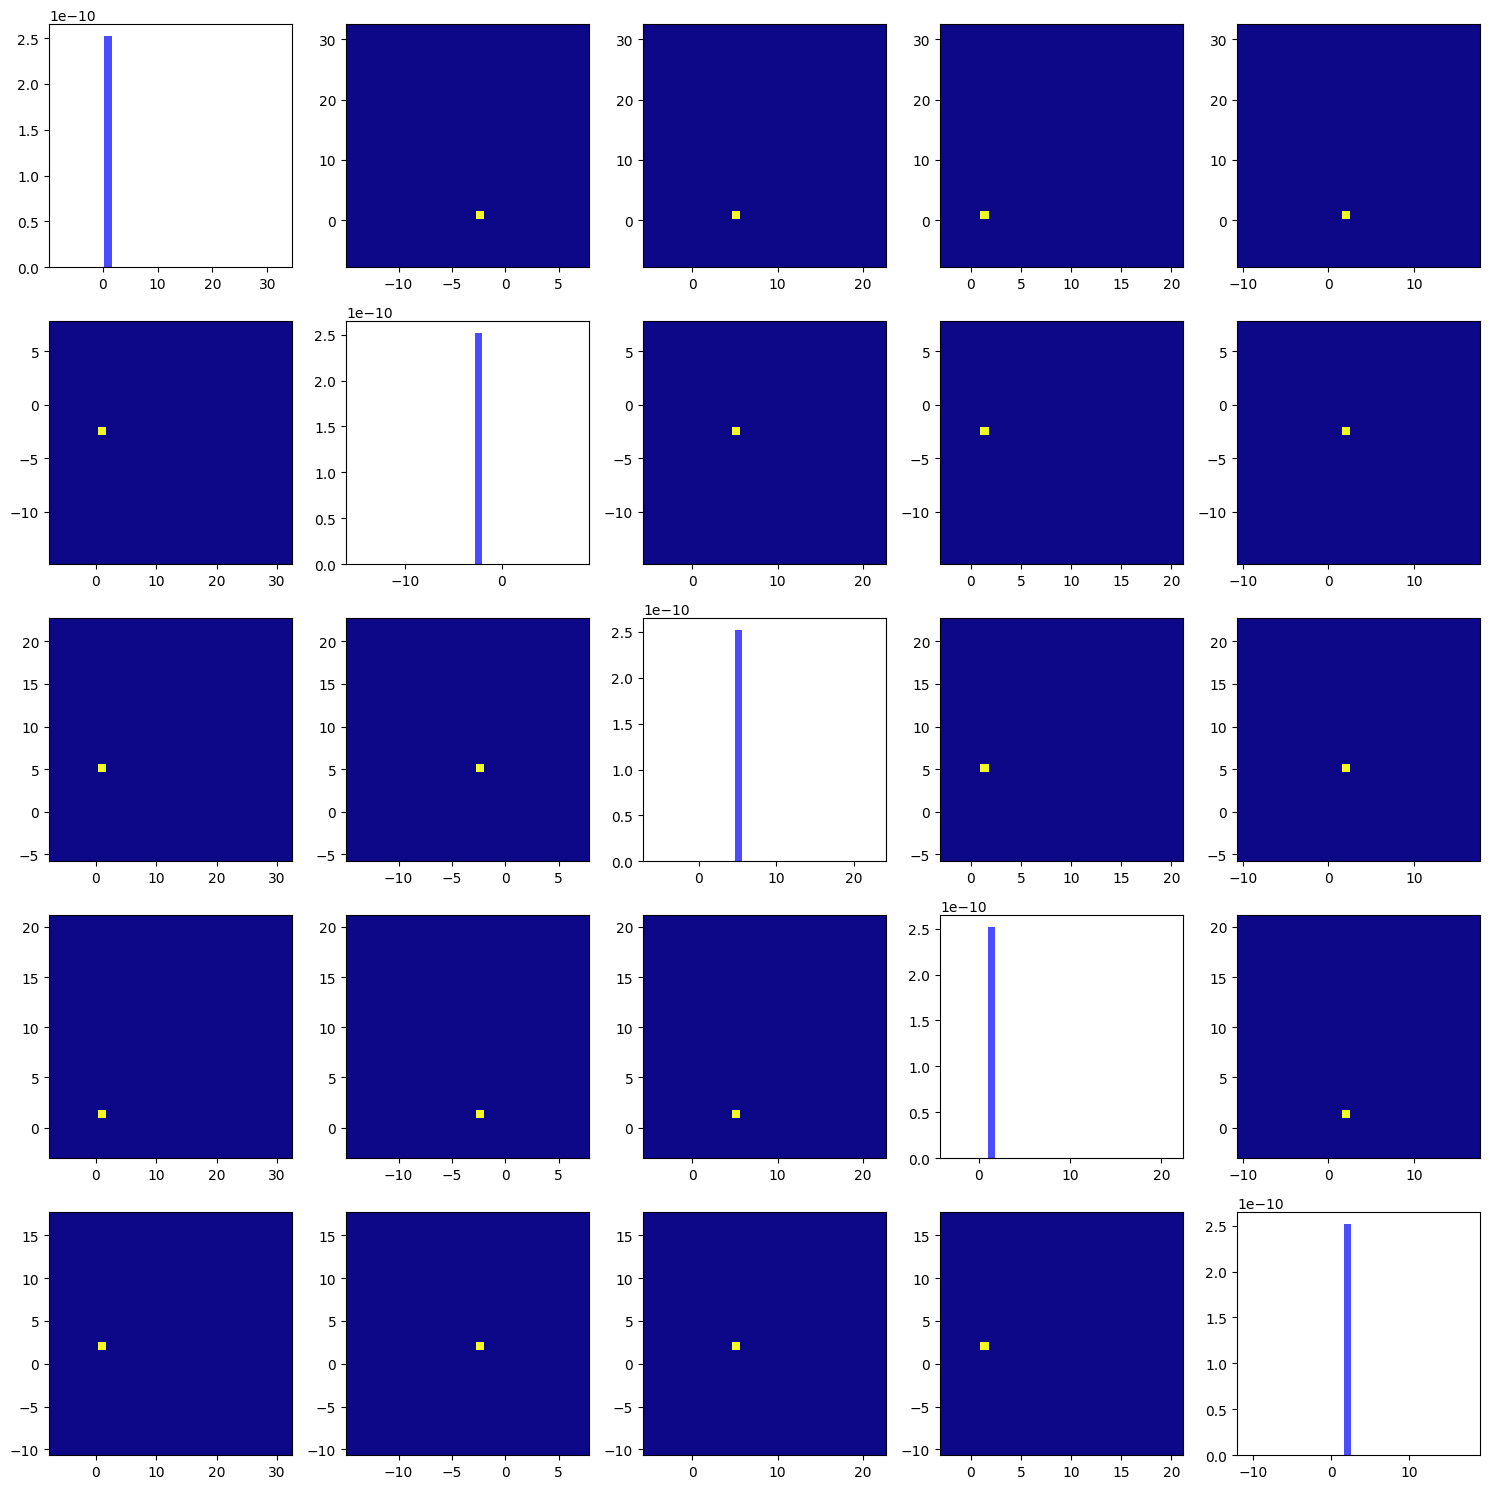

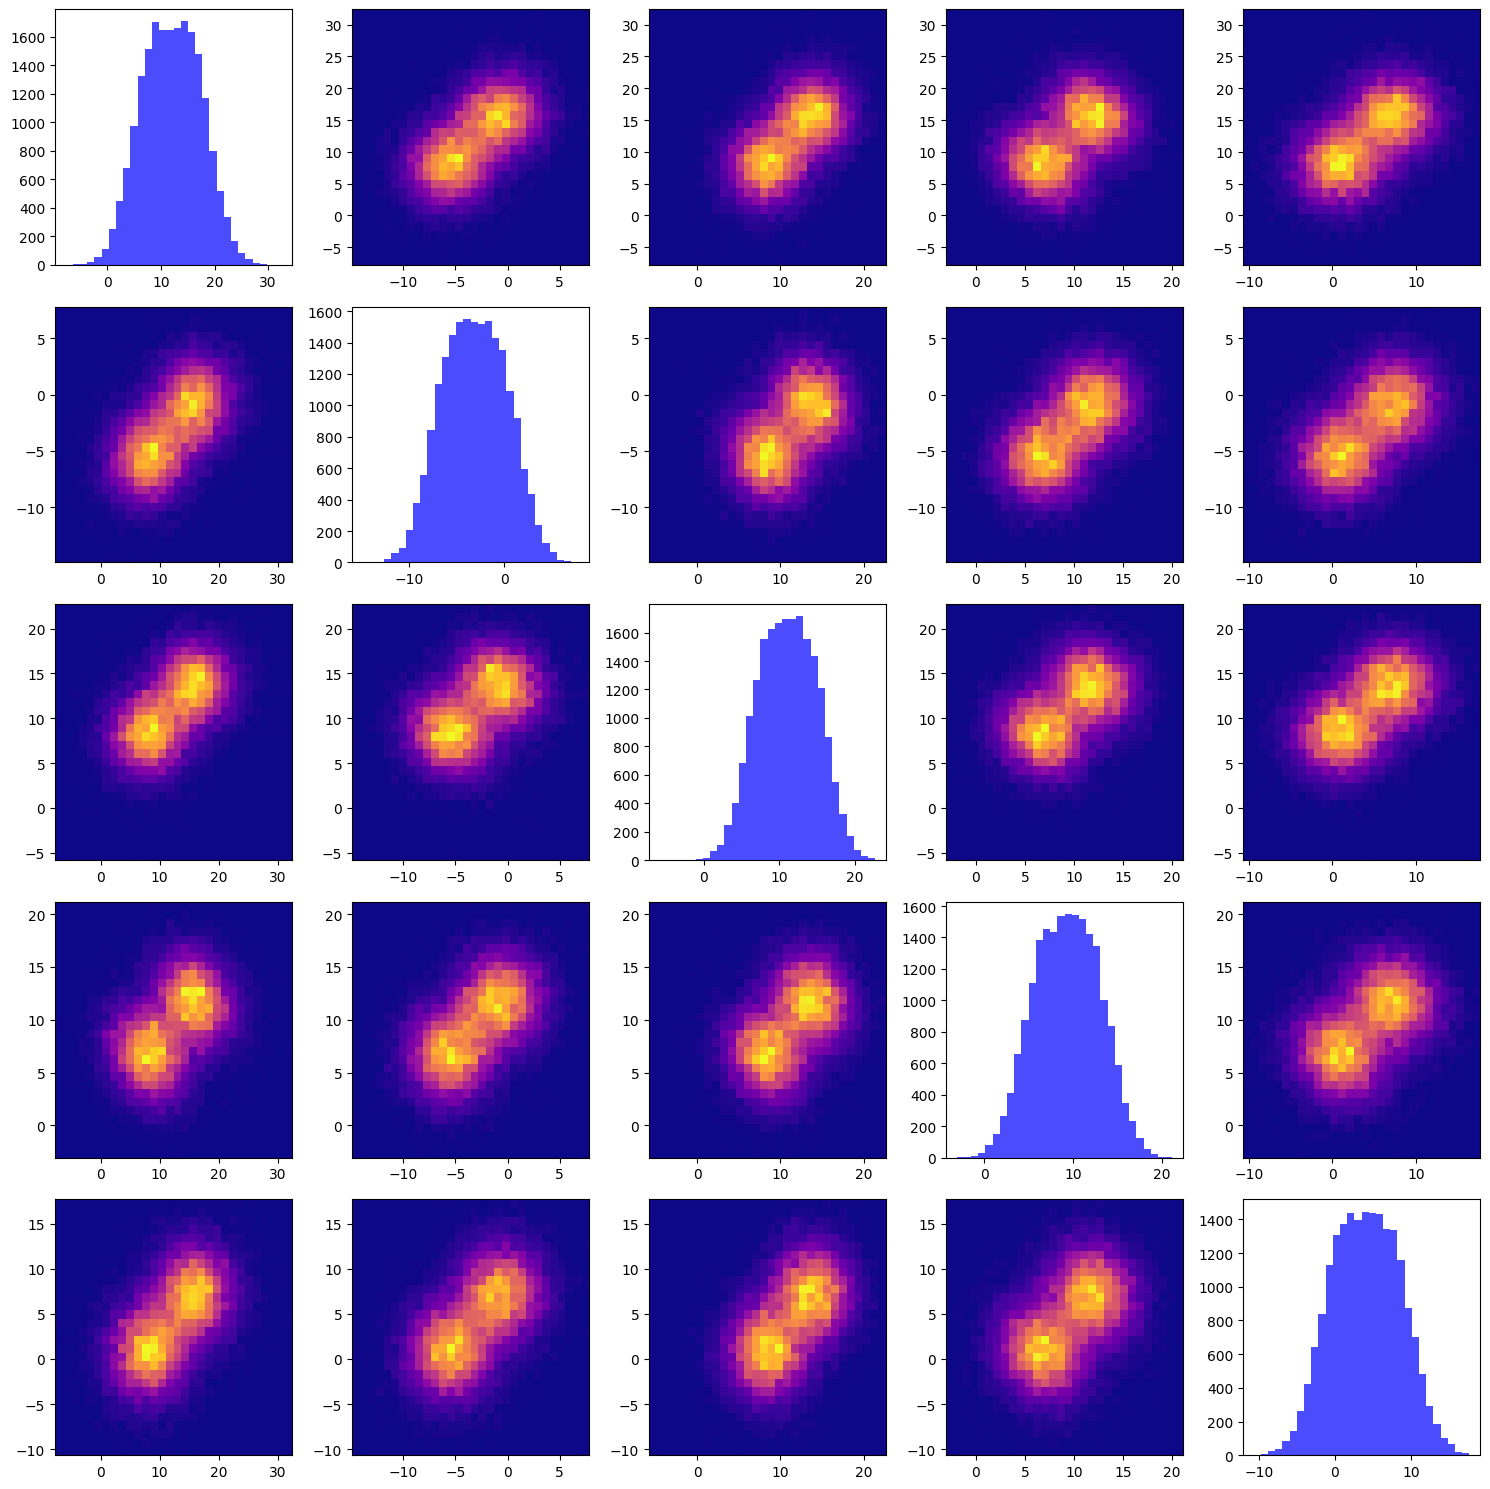

In [1]:
# In [1]:
# (Optional) Generate the data if you haven't already.
# Just copy/paste the "Generate a Higher-Dimensional Synthetic Dataset" code here.

# In [2]:
from dataset_class import SystematicDataset

# Instantiate the dataset
dataset = SystematicDataset(
    data_file='synthetic_double_gaussian_5D.npz', 
    start_conditional=2  # Example: treat first 2 dims as "conditional"
)

print("Number of samples:", len(dataset))
print("Data dimensionality:", dataset.ndim)

# Grab one sample
idx = 42
data_cond, data_rem, single_gauss_nll, neg_log_p = dataset[idx]

print(f"\nSample index {idx} =>")
print("  single_gaussian_log_density (standard Gauss NLL):", single_gauss_nll)
print("  negative_log_p (precomputed):", neg_log_p)

dataset.plot_histo_data(
    n_sample=20000, 
    n_bins=30, 
    eigen=True,       # If True, would plot in "eigenspace" = dataset.data
    gaussian_reweight=True
)

dataset.plot_histo_data(
    n_sample=20000, 
    n_bins=30, 
    eigen=True,       # If True, would plot in "eigenspace" = dataset.data
    gaussian_reweight=False
)

In [3]:
print(dataset.cov)

tensor([[ 9.0306, -0.6245,  0.2216, -2.3029,  3.4310],
        [-0.6245, 14.8017,  3.7430,  6.1261, -2.5999],
        [ 0.2216,  3.7430,  7.9576,  1.0993, -2.7355],
        [-2.3029,  6.1261,  1.0993, 11.5639, -2.4090],
        [ 3.4310, -2.5999, -2.7355, -2.4090, 12.3886]])
